In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict["p"], dict["a"], dict["l"], dict["s"]

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if round(i.attrs["pointiness"],5) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],5))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

def getRuns(spacing,pointiness,length):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)*100+abs(run.attrs["length"]-length)*1e9
        if dist<0.01:
            runs.append(run)
    
    return runs



data=[]
filePrefix="data/"
for name in glob.glob(filePrefix+"*.out"):
    try:
        thisData=loadFile(name+"/table.txt")
    except Exception:
        print(f"Could not load {name}")
        continue
    desc=name[len(filePrefix):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    data.append(thisData)

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)
print(getPossibleVals(data))



([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], [2.8e-07], [2e-07])


In [2]:
def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)<3:
                    if len(runs)>0:
                        print(pointiness,spacing,length)
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData

data = removeDuplicateRuns(data)


                



Inconsistent data for 0.24, 2.8e-07, 2e-07
Inconsistent data for 0.25, 2.8e-07, 2e-07
Inconsistent data for 0.33, 2.8e-07, 2e-07
Inconsistent data for 0.49, 2.8e-07, 2e-07
Fixed data for 19/101 runs. 4 runs unfixable, 0 not enough data


(array([0]),)
(array([1]),)
(array([2]),)
(array([3]),)
(array([4]),)
(array([5]),)
(array([6]),)


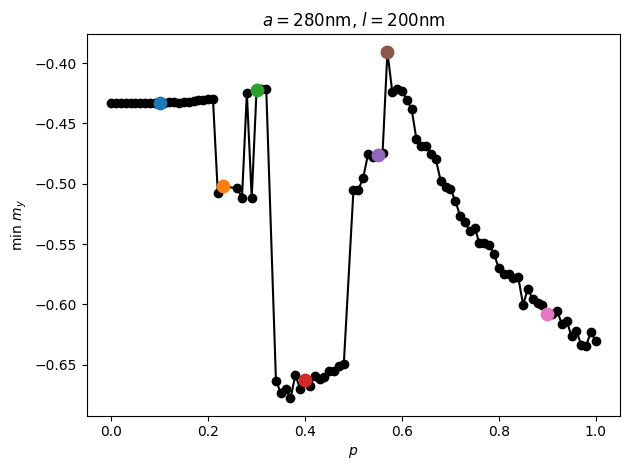

/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_29069/1251855139.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=10)


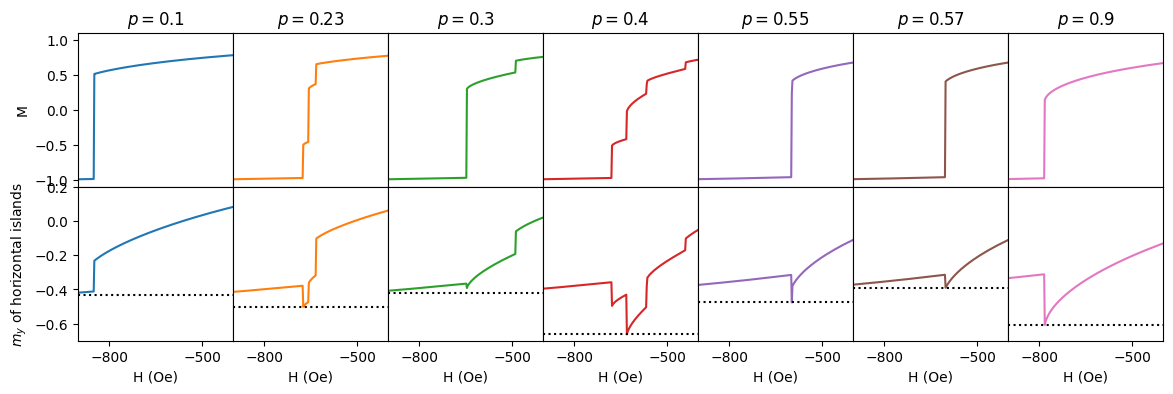

In [125]:
colorOrder=plt.rcParams['axes.prop_cycle'].by_key()['color']

keyPointinesses=np.array([0.1,0.23,0.3,0.4,0.55,0.57,0.9])

pointinesses=[]
minMys=[]

fig=plt.figure()
#fig.set_size_inches(14,4)

for pointiness in pointinessVals:
    run = getRuns(280e-9,pointiness,200e-9)
    if len(run) != 1: 
        continue
    run=run[0]

    pointinesses.append(pointiness)
    minMys.append(min(run["hIsland_my"]))

    if pointiness in keyPointinesses:
        print(np.where(keyPointinesses == pointiness))
        plt.scatter(pointiness,minMys[-1],zorder=200,s=80)

plt.plot(pointinesses,minMys,"o-",color="k")
plt.xlabel("$p$")
plt.ylabel("min $m_y$")
plt.title("$a=280$nm, $l=200$nm")
plt.tight_layout()
plt.savefig("main.png")
plt.show()




fig, (row1,row2) = plt.subplots(2,len(keyPointinesses),sharex=True)

for i,pointiness in enumerate(keyPointinesses):
    plt.subplots_adjust(wspace=0, hspace=-10)
    fig.set_size_inches(14,4)

    ax1=row1[i]
    ax2=row2[i]

    run = getRuns(280e-9,pointiness,200e-9)
    if len(run) != 1: continue
    run=run[0]
    ax2.plot(run["H"],run["hIsland_my"],label=f"$p={pointiness}$",color=colorOrder[i])
    ax1.plot(run["H"],run["m"],color=colorOrder[i])
    ax2.axhline(min(run["hIsland_my"]),ls=":",color="k")

    
    ax1.axes.get_xaxis().set_visible(False)
    #ax2.axes.get_xaxis().set_visible(False)
    ax2.set_xlabel("H (Oe)")
    if i==0:
        ax2.set_ylabel("$m_y$ of horizontal islands")
        ax1.set_ylabel("M")
    else:
        ax1.axes.get_yaxis().set_visible(False)
        ax2.axes.get_yaxis().set_visible(False)
    ax2.set_xlim(-900,-400)
    ax1.set_xlim(-900,-400)
    ax2.set_ylim(-0.7,0.2)
    ax1.set_title(f"$p={pointiness}$")
    ax2.set_xlabel("H (Oe)")
    ax2.set_xticks([-800,-500])

plt.tight_layout(pad=10)
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig(f"inspect.png")
plt.show()


